# Generation of Ondřejov Dataset

The data should be provided in `data/` directory. FITS files have to be in `data/fist/` and label in `data/labels.csv`.

In [1]:
import glob
import random
import pandas
import numpy
import astropy
import astropy.convolution
from matplotlib import pyplot

In [2]:
%matplotlib inline

In [3]:
# read dataset labels
labels = pandas.read_csv('data/labels.csv', index_col='id')
labels.head()

,label
id,
a201306060018,0
a201306060019,0
a201306070013,0
a201306080018,0
a201306080020,0


In [4]:
def compute_waves(hdulist):
    """Compute spectrum's wavelengths from Ondřejov FITS file."""
    header = hdulist[0].header
    w = astropy.wcs.WCS(header)
    pixcrd = numpy.arange(header['NAXIS1'])
    return w.all_pix2world(pixcrd, 0)[0]

def get_spectrum(hdulist):
    """Return tuple of wavelengths and fluxes from Ondřejov FITS file."""
    waves = compute_waves(hdulist)
    fluxes = hdulist[0].data
    return waves, fluxes

def air2vacuum(air_waves):
    """Convert air wavelengths to vacuum wavelengths according to
    http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion.
    """
    # http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion    
    ss = ((10 ** 4) / air_waves) ** 2
    return air_waves * (1 + 0.00008336624212083 + 0.02408926869968 / \
            (130.1065924522 - ss) + 0.0001599740894897 / (38.92568793293 - ss))

def convolve_fluxes(fluxes, kernel=astropy.convolution.Gaussian1DKernel(stddev=7)):
    """Perform convolution with kernel of spectrum's fluxes.
    Default is Gaussian kernel with standard deviation of value 7.
    """
    return astropy.convolution.convolve(fluxes, kernel, boundary='extend')

def resample_fluxes(waves, fluxes, new_waves=numpy.linspace(6519, 6732, 140)):
    """Resample fluxes to fixed set of `new_waves` wavelengths.
    This operation allows to create design matrix for machine learning.
    """
    return numpy.interp(new_waves, waves, fluxes)

def preprocess_fluxes(waves, fluxes):
    """Wrapper function that applies all preprocessin procedures to a spectrum."""
    vacuum_waves = air2vacuum(waves)
    convolved_fluxes = convolve_fluxes(fluxes)
    resampled_fluxes = resample_fluxes(vacuum_waves, convolved_fluxes)
    return resampled_fluxes

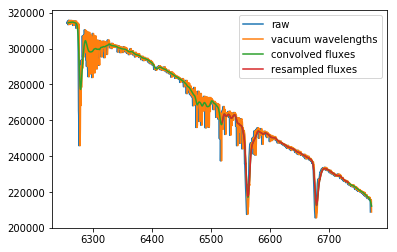

In [5]:
# example spectrum preprocessing
with astropy.io.fits.open(random.choice(glob.glob('data/fits/*.fits'))) as hdulist:
    air_waves, fluxes = get_spectrum(hdulist)
    pyplot.plot(air_waves, fluxes, label='raw')
    vacuum_waves = air2vacuum(air_waves)
    pyplot.plot(vacuum_waves, fluxes, label='vacuum wavelengths')
    convolved_fluxes = convolve_fluxes(fluxes)
    pyplot.plot(vacuum_waves, convolved_fluxes, label='convolved fluxes')
    resampled_fluxes = resample_fluxes(vacuum_waves, convolved_fluxes)
    pyplot.plot(numpy.linspace(6519, 6732, 140), resampled_fluxes, label='resampled fluxes')
    pyplot.legend()

In [6]:
spectra = {}
for name, label in labels.itertuples():
    with astropy.io.fits.open('data/fits/' + name + '.fits') as hdulist: 
        header = hdulist[0].header
        spectra[name] = {'fluxes': preprocess_fluxes(*get_spectrum(hdulist)),
                          'label': label,
                          'object': header['OBJECT'],
                          'ra': header['RA'],
                          'dec': header['DEC'],
                          'expval': header['EXPVAL'],
                          'gratang': header['GRATANG'],
                          'detector': header['DETECTOR'],
                          'chipid': header['CHIPID'],
                          'specfilt': header['SPECFILT'],
                          'date-obs': header['DATE-OBS'],
                          'dichmir': header['DICHMIR']}

df = pandas.DataFrame.from_dict(spectra, orient='index')
df[numpy.linspace(6519, 6732, 140)] = pandas.DataFrame(df['fluxes'].values.tolist(), index=df.index)
del df['fluxes']
df.index.name = 'id'
df.to_csv('data/ondrejov-dataset.csv')
df.head()

,label,date-obs,gratang,expval,ra,dichmir,object,specfilt,dec,chipid,...,6718.20863309,6719.74100719,6721.27338129,6722.8057554,6724.3381295,6725.8705036,6727.4028777,6728.9352518,6730.4676259,6732.0
id,,,,,,,,,,,,,,,,,,,,,
a201305230017,1,2013-05-23,30.25,19.246130,13:25:11.580,2,alp Vir,1,-11:09:40.70,E2V 42-10 BX,...,506096.210748,505286.047228,504106.925201,502043.387652,499827.958541,498385.165956,498190.044968,499302.148265,500607.698358,500899.192757
a201306060015,1,2013-06-06,30.25,0.009187,14:15:39.667,2,alp Boo,1,+19:10:56.60,E2V 42-10 BX,...,193644.604516,194951.353066,200427.247481,203353.778155,203940.311357,203613.661065,202053.255088,202003.060090,203675.565714,204506.290588
a201306060016,1,2013-06-06,30.25,0.012332,14:15:39.667,2,alp Boo,1,+19:10:56.60,E2V 42-10 BX,...,307559.413555,309575.702337,318283.859189,323097.056161,324141.074458,323543.630765,320970.267304,320887.844222,323502.907113,324655.685273
a201306060018,0,2013-06-06,30.25,5.056532,18:50:04.787,2,beta Lyr,1,+33:21:45.60,E2V 42-10 BX,...,44950.487947,45019.574545,44910.009841,44719.100229,44689.037403,44724.791337,44700.993767,44705.082297,44752.548428,44734.531766
a201306060019,0,2013-06-06,30.25,15.040130,18:50:04.787,2,beta Lyr,1,+33:21:45.60,E2V 42-10 BX,...,125795.778619,126004.868747,125788.287910,125227.841525,125145.712758,125330.650720,125332.395056,125338.057872,125376.976633,125252.358114
